# Project description

The goal is to prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry.

The model should predict the amount of gold recovered from gold ore. We have the data on extraction and purification.
The model will help to optimize the production and eliminate unprofitable parameters.

## Prepare the data

In [72]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import RandomState
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from numpy.random import RandomState
from pprint import pprint
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

### Open the files and look into the data

In [73]:
try:
    gr_train = pd.read_csv('gold_recovery_train.csv')
    gr_test = pd.read_csv('gold_recovery_test.csv')
    gr_full = pd.read_csv('gold_recovery_full.csv')
except:
    gr_train = pd.read_csv('/datasets/gold_recovery_train.csv')
    gr_test = pd.read_csv('/datasets/gold_recovery_test.csv')
    gr_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [74]:
gr_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [75]:
#gr_test.info()

In [76]:
gr_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


### Check that recovery is calculated correctly

Using the training set, calculate recovery for the rougher.output.recovery feature. 

Find the MAE between your calculations and the feature values.

Recovery calculation
We need to simulate the process of recovering gold from gold ore.


C — share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)

F — share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)

T — share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)


In [77]:
C = gr_train['rougher.output.concentrate_au']
F = gr_train['rougher.input.feed_au']
T = gr_train['rougher.output.tail_au']
gr_train['recovery_check'] = ((C*(F-T))/(F*(C-T)))*100
gr_train.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,recovery_check
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,86.842308
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,87.226430
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,86.688794


In [78]:
diff = abs(gr_train['recovery_check']- gr_train['rougher.output.recovery'])
diff = diff.dropna()
MAE = (diff.sum())/len(diff)
MAE

9.303415616264301e-15

**We can assume that recovery is calculated correctly.**

### Analyze the features not available in the test set

In [79]:
gr_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [80]:
try:
    gr_train = pd.read_csv('gold_recovery_train.csv')
except:
    gr_train = pd.read_csv('/datasets/gold_recovery_train.csv')

train_cols = gr_train.columns
test_cols = gr_test.columns

common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)
train_not_test

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

**The features that are not available in the test set are the ones that reference the outputs at different stages. All the calculated features are missing. The only ones left are the inputs.**

### Data preprocessing

**Change datatype**

In [81]:
#gr_train['date'] = pd.to_datetime(gr_train['date'])
#gr_test['date'] = pd.to_datetime(gr_train['date'])
#gr_full['date'] = pd.to_datetime(gr_train['date'])

**Fill in missing values**

Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar. We will use that for the missing values. 

In [82]:
targets = ['rougher.output.recovery', 'final.output.recovery']
features = [x for x in gr_full if x not in targets and x != 'date']

In [83]:
gr_full[features] = gr_full[features].fillna(method='ffill')

In [84]:
gr_full[targets].isna().sum()

rougher.output.recovery    3119
final.output.recovery      1963
dtype: int64

In [85]:
gr_test = pd.merge(gr_test, gr_full[['date', 'final.output.recovery', 'rougher.output.recovery']],
                     on='date',
                     how='left'
                    )


gr_train = gr_train.drop(columns=[x for x in gr_train if x not in gr_test], axis=1)


gr_test = gr_test.drop(columns=[x for x in gr_test if x not in gr_train], axis=1)

In [86]:
#Create a MinMaxScaler instance.
scaler = MinMaxScaler()

#Create lists for columns to scale and not to scale.
scale_columns = [x for x in gr_train.columns if x  not in ['date', 'rougher.output.recovery', 'final.output.recovery']]
non_scale_columns = ['date', 'rougher.output.recovery', 'final.output.recovery']

#Scale data in scale_columns for training and testing datasets.
gr_train_scaled = pd.DataFrame(scaler.fit_transform(gr_train[scale_columns].copy()), columns = scale_columns)
gr_test_scaled = pd.DataFrame(scaler.transform(gr_test[scale_columns].copy()), columns = scale_columns)

In [87]:
%%time
#Create instance of KNNImputer class.
imputer = KNNImputer()

#Scale values in both DataFrames and add the 'date' column back to each.
gr_train_scaled = pd.concat([gr_train[non_scale_columns]] + \
                              [pd.DataFrame(imputer.fit_transform(gr_train_scaled), \
                               columns=gr_train_scaled.columns)], axis = 1)

gr_test_scaled = pd.concat([gr_test[non_scale_columns]] + \
                             [pd.DataFrame(imputer.transform(gr_test_scaled), \
                              columns=gr_test_scaled.columns)], axis = 1)

CPU times: user 17.3 s, sys: 2.63 s, total: 19.9 s
Wall time: 20 s


In [88]:
#Drop rows with NaNs in target columns.
gr_train_scaled = gr_train_scaled.dropna().reset_index(drop=True)
gr_test_scaled = gr_test_scaled.dropna().reset_index(drop=True)

In [89]:
gr_train_scaled.isna().sum()

date                                          0
rougher.output.recovery                       0
final.output.recovery                         0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                   

In [90]:
gr_test_scaled.isna().sum()

date                                          0
rougher.output.recovery                       0
final.output.recovery                         0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                   

## Analyze the data

### Concentrations of metals (Au, Ag, Pb) change depending on the purification stage

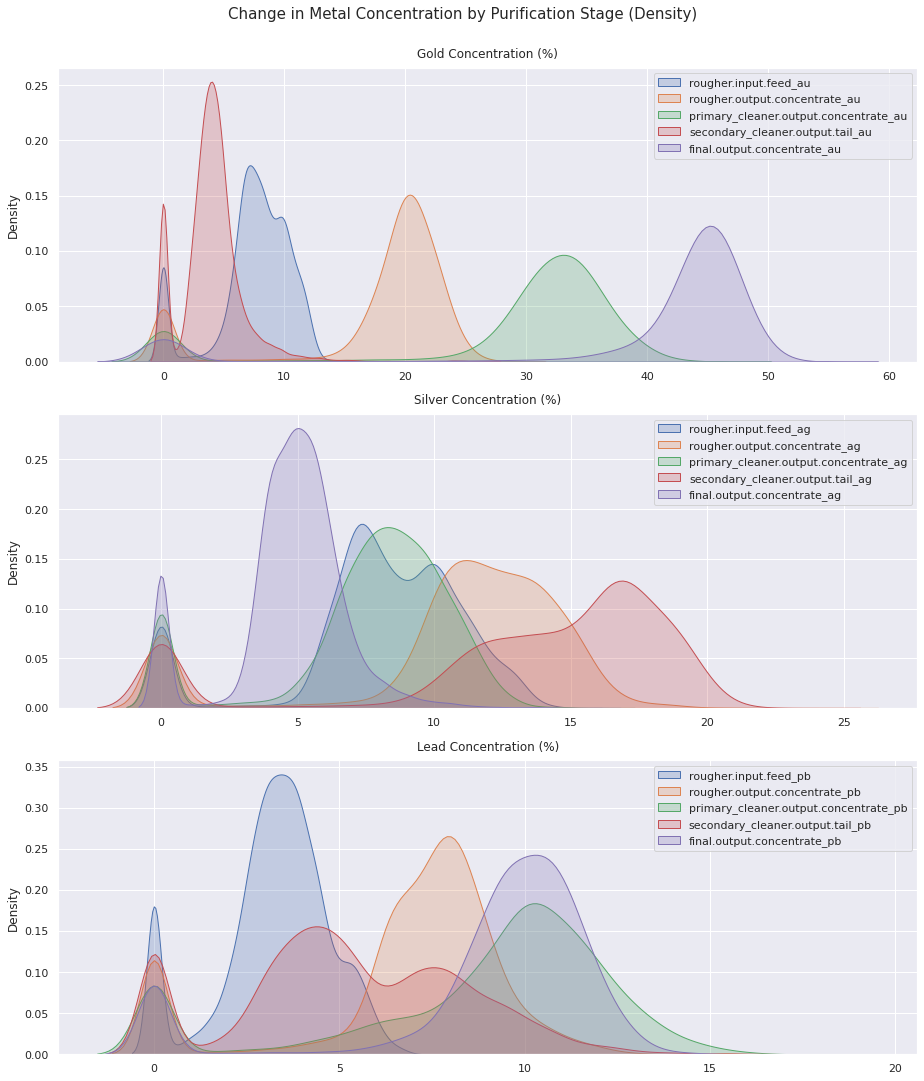

In [91]:
#Create list of variable handles to examine for each metal.
concen = ["rougher.input.feed", "rougher.output.concentrate", "primary_cleaner.output.concentrate","secondary_cleaner.output.tail", "final.output.concentrate"]

#Create dictionary to map each metal's unique variable identifier with it's name.
metals = {'_au' : 'Gold', '_ag' : 'Silver', '_pb' : 'Lead'}

#Create subplots to visualize each metals concentration after each purification stage.
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(13, 15), sharey=False)
fig.suptitle('Change in Metal Concentration by Purification Stage (Density)', fontsize=15, y=1)

for x in metals.keys():
    for c in concen:
        ax = list(metals.keys()).index(x)
        sns.kdeplot(gr_full[(c+x)], ax=axes[ax], shade='fill', label=(c+x))
        axes[ax].legend()
        axes[ax].set_xlabel(metals[x] + ' Concentration (%)', fontsize=12, labelpad = 10)
        axes[ax].xaxis.set_label_position('top')
        axes[ax].set_ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()

As expected the concentration of gold increases after each purification stage.

We can notice that there are many zeros in our data. it's hard to say if it's not abnormal or missing values. These values can be considered as outliers.

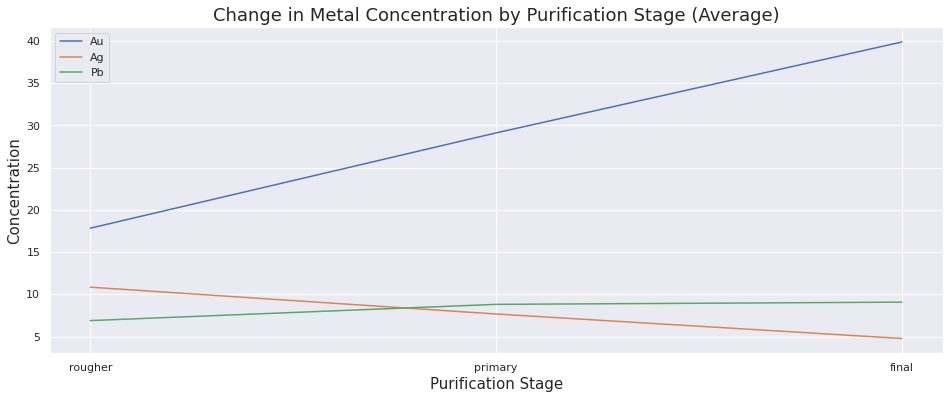

In [92]:
name_conc = np.array([['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'],
                      ['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'],
                      ['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]
                    )
name_stage = ['rougher', 'primary', 'final']
me=['Au', 'Ag', 'Pb']
sns.set()
f, axes = plt.subplots(1, 1, figsize=(16, 6))
axes.set_title('Change in Metal Concentration by Purification Stage (Average)', fontsize=18)
axes.set_ylabel('Concentration', fontsize=15)
axes.set_xlabel('Purification Stage', fontsize=15)
for cons, met in zip(name_conc, me):
    sns.lineplot(data = pd.Series(gr_full[cons].mean().values, index=name_stage),legend = 'full',label = met)

plt.show()

Average concentration of gold increases with each stage, other metals seem to stay within the same range.

### Feed particle size distributions 

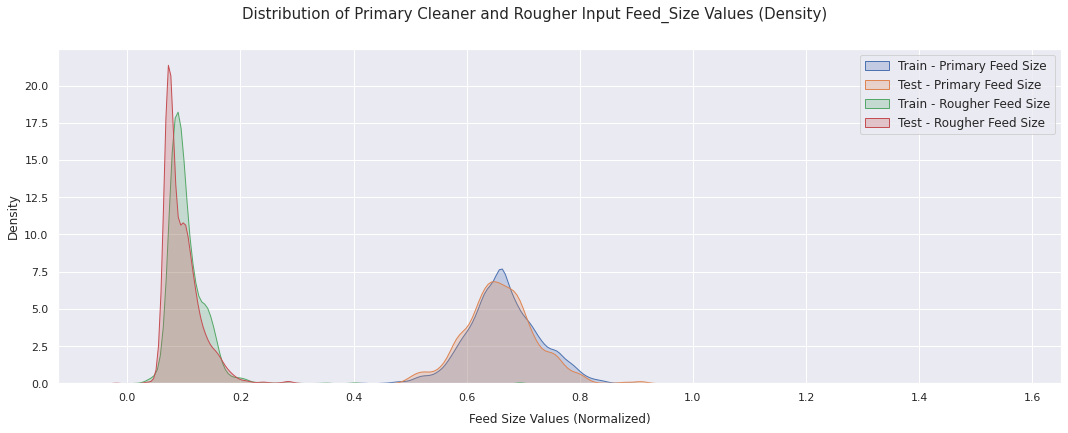

In [93]:
fig = plt.figure(figsize=(15, 6))
fig.suptitle('Distribution of Primary Cleaner and Rougher Input Feed_Size Values (Density)', fontsize=15, y=1)

sns.kdeplot(gr_train_scaled['primary_cleaner.input.feed_size'], fill=True, label='Train - Primary Feed Size')
sns.kdeplot(gr_test_scaled['primary_cleaner.input.feed_size'], fill=True, label='Test - Primary Feed Size')
sns.kdeplot(gr_train_scaled['rougher.input.feed_size'], fill=True, label='Train - Rougher Feed Size')
sns.kdeplot(gr_test_scaled['rougher.input.feed_size'], fill=True, label='Test - Rougher Feed Size')
plt.legend(fontsize=12)
plt.xlabel('Feed Size Values (Normalized)', fontsize=12, labelpad = 10)
plt.ylabel('Density', fontsize=12)
#plt.xlim(0,100)
plt.tight_layout()
plt.show()

The feed particle size distributions in the training set and in the test set do not vary significantly according to the comparison. 
But we should keep in mind that now it's not the real size, since the data have been scaled.

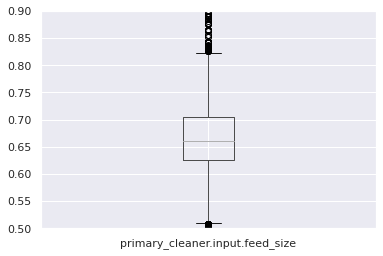

In [94]:
boxplot = gr_train_scaled.boxplot(column=['primary_cleaner.input.feed_size'])#, 'rougher.input.feed_size'])
plt.ylim(0.5,0.9)
plt.show()


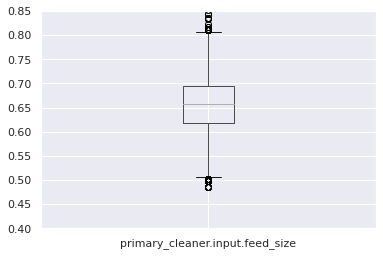

In [95]:
boxplot = gr_test_scaled.boxplot(column=['primary_cleaner.input.feed_size'])#, 'rougher.input.feed_size'])
plt.ylim(0.4, 0.85)
plt.show()

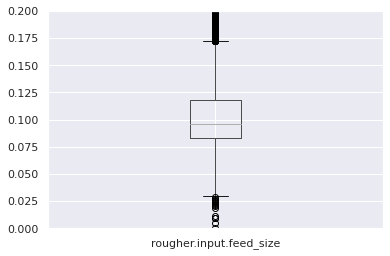

In [96]:
boxplot = gr_train_scaled.boxplot(column=['rougher.input.feed_size'])
plt.ylim(0, 0.2)
plt.show()


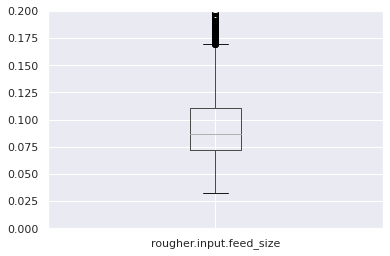

In [97]:
boxplot = gr_test_scaled.boxplot(column=['rougher.input.feed_size'])
plt.ylim(0, 0.2)
plt.show()

### Total concentrations of all substances at different stages

In [98]:
def metal_concen_sum(df, stage):
    metal_handles = list(metals.keys())
    total_concen = df[stage+metal_handles[0]] + df[stage+metal_handles[1]] + df[stage+metal_handles[2]]
    return total_concen

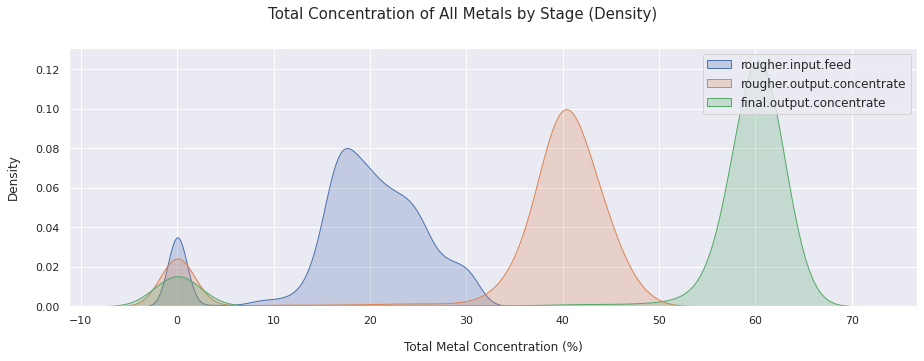

In [99]:
fig = plt.figure(figsize=(13, 5))
fig.suptitle('Total Concentration of All Metals by Stage (Density)', fontsize=15, y=1)

sns.kdeplot(metal_concen_sum(gr_full, 'rougher.input.feed'), label='rougher.input.feed', fill=True)
sns.kdeplot(metal_concen_sum(gr_full, 'rougher.output.concentrate'), label='rougher.output.concentrate', fill=True)
sns.kdeplot(metal_concen_sum(gr_full, 'final.output.concentrate'), label='final.output.concentrate', fill=True)
plt.legend(fontsize=12)
plt.xlabel('Total Metal Concentration (%)', fontsize=12, labelpad = 15)
plt.ylabel('Density', fontsize=12, labelpad=15)
    
plt.tight_layout()
plt.show()

As we noted before values around 0 can be considered anomalies.
For the cleaner data we will remove them.

In [100]:
gr_full_filt = gr_full.loc[(gr_full[['rougher.input.feed_au', 'rougher.input.feed_pb', \
                                               'rougher.input.feed_ag']].sum(axis=1) > 10) \
                                  & (gr_full[['rougher.output.concentrate_au', 'rougher.output.concentrate_pb', \
                                                 'rougher.output.concentrate_ag']].sum(axis=1) > 10) \
                                  & (gr_full[['final.output.concentrate_au', 'final.output.concentrate_pb', \
                                                'final.output.concentrate_ag']].sum(axis=1) > 10)]

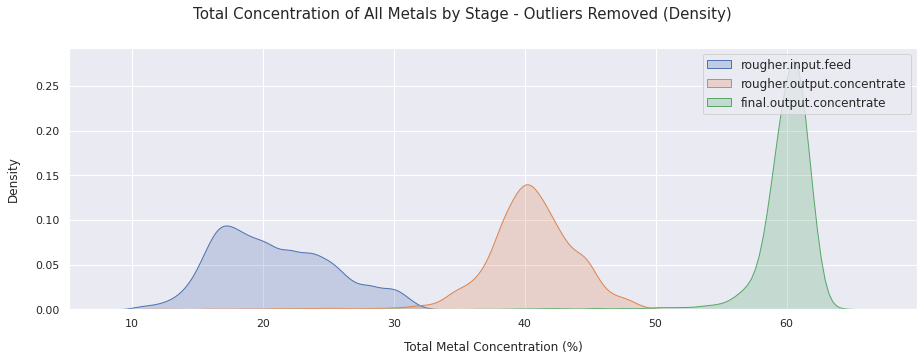

In [101]:
#Create plot to visualize total concentration of all metals at certain stages in dataset with outliers removed.
fig = plt.figure(figsize=(13, 5))
fig.suptitle('Total Concentration of All Metals by Stage - Outliers Removed (Density)', fontsize=15, y=1)

sns.kdeplot(metal_concen_sum(gr_full_filt, 'rougher.input.feed'), label='rougher.input.feed', fill=True)
sns.kdeplot(metal_concen_sum(gr_full_filt, 'rougher.output.concentrate'), label='rougher.output.concentrate', fill=True)
sns.kdeplot(metal_concen_sum(gr_full_filt, 'final.output.concentrate'), label='final.output.concentrate', fill=True)
plt.legend(fontsize=12)
plt.xlabel('Total Metal Concentration (%)', fontsize=12, labelpad = 12)
plt.ylabel('Density', fontsize=12, labelpad=15)
    
plt.tight_layout()
plt.show()

In [102]:
total_before = [len(gr_train), len(gr_test)]

#Remove outliers from scaled testing and training datasets based on whether date is in gold_full_no_outliers.
gr_train_scaled = gr_train_scaled.loc[gr_train_scaled['date'].isin(gr_full_filt['date'])].reset_index(drop=True)
gr_test_scaled = gr_test_scaled.loc[gr_test_scaled['date'].isin(gr_full_filt['date'])].reset_index(drop=True)

#Display lengths of datasets before and after removing outliers, as well as percentage of difference.
display(pd.DataFrame([[total_before[0], len(gr_train_scaled), round((100 - (len(gr_train_scaled) / total_before[0]) * 100), 2)], \
                      [total_before[1], len(gr_test_scaled), round((100 - (len(gr_test_scaled) / total_before[1]) * 100), 2)]], \
                    columns = ['Initial Length', 'New Length', 'Difference (%)'], index=['Train', 'Test']))

,Initial Length,New Length,Difference (%)
Train,16860,13659,18.99
Test,5856,5133,12.35


## Build the model

### Final sMAPE value

In [103]:
#Create function to calculate sMAPE.
def smape2(y_true, y_pred):
    smape = np.mean(abs(y_pred - y_true) / ((abs(y_true) + abs(y_pred)) / 2)) * 100
    return smape

#Create function to calculate final sMAPE.
def f_smape(y_true, y_pred):
    predicted_rough, predicted_final = y_pred[:, 0], y_pred[:, 1]
    true_rough, true_final = y_true[:, 0], y_true[:, 1]
    f_smape = (.25 * (smape2(true_rough, predicted_rough))) + (.75 * (smape2(true_final, predicted_final)))
    return f_smape

### Model training

In [104]:
targets = ['rougher.output.recovery', 'final.output.recovery']
features = [x for x in gr_train if x not in targets and x != 'date']

In [105]:
gr_train_scaled.describe()

,rougher.output.recovery,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,13659.000000,13659.000000,13659.000000,13659.000000,13659.000000,13659.000000,13659.000000,13659.000000,13659.000000,13659.000000,...,13659.000000,13659.000000,13659.000000,13659.000000,13659.000000,13659.000000,13659.000000,13659.000000,13659.000000,13659.000000
mean,84.595874,66.965182,0.533333,0.222174,0.665802,0.146551,0.772802,0.662947,0.680812,0.671059,...,0.332596,0.478386,0.553097,0.466343,0.270791,0.602387,0.320348,0.465562,0.357623,0.394014
std,7.796614,9.027345,0.153040,0.083842,0.064984,0.062338,0.062220,0.076746,0.055954,0.073083,...,0.094225,0.075664,0.188388,0.080549,0.091571,0.072978,0.146020,0.057463,0.104458,0.048199
min,2.520854,0.463711,0.000012,0.000000,0.000000,0.000000,0.000003,0.002970,0.000004,0.129882,...,0.000000,0.000318,0.000000,0.000221,0.000806,0.004953,0.005559,0.000371,0.003118,0.001395
25%,80.424855,62.832615,0.430097,0.151172,0.627263,0.100426,0.765680,0.637900,0.657424,0.646389,...,0.249794,0.445224,0.424995,0.411596,0.181394,0.570601,0.217285,0.441357,0.272857,0.401872
50%,85.546600,67.521225,0.531010,0.200927,0.662407,0.146983,0.770261,0.638706,0.678310,0.647338,...,0.333358,0.446637,0.534677,0.412660,0.289098,0.571882,0.293578,0.441639,0.363925,0.402771
75%,90.299288,72.409614,0.635197,0.287042,0.705005,0.182610,0.817339,0.639853,0.720002,0.648528,...,0.416508,0.521150,0.716570,0.549000,0.340277,0.635317,0.445194,0.514420,0.455174,0.403456
max,99.979041,100.000000,0.992571,0.501306,1.000000,0.416889,1.000000,1.000000,0.895610,0.976049,...,0.501929,0.825139,0.857308,0.898979,0.694578,1.000000,0.697603,0.945292,0.586384,0.916124


In [106]:
#Split training and testing datasets by features and targets.
y_train, y_test = gr_train_scaled[targets].values, gr_test_scaled[targets].values
X_train, X_test = gr_train_scaled[features].values, gr_test_scaled[features].values

In [107]:
smape = make_scorer(f_smape, greater_is_better=False)

#Create function to train and fit models using GridSearchCV
def train_fit_score(model, params, name):
    model = GridSearchCV(model, param_grid=params, cv=5, scoring=smape, verbose=0, refit=True)
    model.fit(X_train, y_train)
    return pd.DataFrame([[name, abs(model.best_score_), model.best_params_]], columns=['Estimator', 'Best Score', 'Best Params'])

In [108]:
%%time
#Create Linear Regressor
LinearRegressor = train_fit_score(LinearRegression(), {}, 'Linear Regressor')

CPU times: user 2.32 s, sys: 3.26 s, total: 5.57 s
Wall time: 5.56 s


In [109]:
%%time
#Create Lasso Regressor
LassoRegressor = train_fit_score(Lasso(random_state=12345), \
                        {'alpha' : np.arange(.01, 1, .05)}, 'Lasso Regressor')

CPU times: user 39.6 s, sys: 55.8 s, total: 1min 35s
Wall time: 1min 35s


In [110]:
LassoRegressor

,Estimator,Best Score,Best Params
0,Lasso Regressor,8.517324,{'alpha': 0.060000000000000005}


In [111]:
%%time
#Create KNeighbors Regressor
KNNeighbors = train_fit_score(KNeighborsRegressor(), 
                        {'n_neighbors' : range(2, 10, 1),
                         'weights' : ['uniform', 'distance']}, 'KNeighbors Regressor')

CPU times: user 59.7 s, sys: 27.6 s, total: 1min 27s
Wall time: 1min 28s


In [112]:
%%time
#Create Random Forest Regressor
RandomForest = train_fit_score(RandomForestRegressor(random_state=12345), 
                       {'n_estimators' : range(10, 85, 25),
                        'max_depth' : range(5, 45, 10),
                        'min_impurity_decrease' : np.arange(.05, .25, .1)}, 'Random Forest')

CPU times: user 26min 21s, sys: 0 ns, total: 26min 21s
Wall time: 26min 34s


In [123]:
RandomForest

,Estimator,Best Score,Best Params
0,Random Forest,8.85922,"{'max_depth': 15, 'min_impurity_decrease': 0.1..."


In [114]:
#Display best scores from all regressors.
scores = pd.concat([LinearRegressor, LassoRegressor, KNNeighbors, RandomForest]).set_index('Estimator')
scores['Best Score'] = scores['Best Score'].round(2)
display(scores.drop('Best Params', axis=1))

,Best Score
Estimator,
Linear Regressor,10.01
Lasso Regressor,8.52
KNeighbors Regressor,9.74
Random Forest,8.86


We've trained 4 models and the best final sMAPE is obtained for random forest model and Lasso Regressor. We will use it for our test dataset.

In [119]:
best_model = RandomForestRegressor(**scores['Best Params'][3]).fit(X_train, y_train)


RandomForest_smape = round(f_smape(y_test, best_model.predict(X_test)), 2)

#Print the result.
print(f'sMAPE score for best Random Forest model on test datasets: {RandomForest_smape}')

sMAPE score for best Random Forest model on test datasets: 7.33


In [118]:
#Create instance of best KNeighbors regression model and fit it to training data.
best_model = Lasso(**scores['Best Params'][1]).fit(X_train, y_train)

#Obtain final sMAPE score for model using testing datasets.
Lasso_smape = round(f_smape(y_test, best_model.predict(X_test)), 2)

#Print the result.
print(f'sMAPE score for best Lasso Regressor model on test datasets: {Lasso_smape}')

sMAPE score for best Lasso Regressor model on test datasets: 6.28


In [116]:
import numpy as np
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")
dr = dummy_regr.fit(X_train, y_train)

smape_sanity = f_smape(y_test, dr.predict(X_test))
print(f'sMAPE score for sanity check model: {round(smape_sanity, 2)}')

sMAPE score for sanity check model: 7.54


We've trained the model with the Lasso Regressor and obtained final sMAPE score prevailing the score for the sanity check model.